In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# 设置随机种子确保可重复性
np.random.seed(42)

# 1. 加载训练集和测试集数据
train_df = pd.read_csv(r'C:\Users\86135\Desktop\5703\train_smote.csv')
test_df = pd.read_csv(r'C:\Users\86135\Desktop\5703\test_smote.csv')
# 假设最后一列为标签，其他列为特征
X_train_raw = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values.astype(np.int64)
X_test_raw = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values.astype(np.int64)

# 将标签从1-4转换为0-3（模型训练使用0索引的类别）
y_train -= 1
y_test -= 1

# 2. 多视图特征预处理
# 标准化（均值0，标准差1）
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train_raw)
X_test_std = scaler_std.transform(X_test_raw)

# Min-Max归一化（0-1区间）
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train_raw)
X_test_mm = scaler_mm.transform(X_test_raw)

# PCA降维（保留95%方差信息量）
pca = PCA(n_components=0.95, random_state=42)
# 在PCA前先对特征标准化（PCA对尺度较敏感）
X_train_for_pca = scaler_std.fit_transform(X_train_raw)  # 在原始训练特征上重新标准化
X_train_pca = pca.fit_transform(X_train_for_pca)
X_test_pca = pca.transform(scaler_std.transform(X_test_raw))
print(f"原始特征维度: {X_train_raw.shape[1]}, PCA后特征维度: {X_train_pca.shape[1]}")

# 3. 划分部分训练集作为验证集用于Early Stopping（例如10%）
val_ratio = 0.1
val_size = int(len(X_train_std) * val_ratio)
if val_size > 0:
    X_val_std = X_train_std[-val_size:];   X_train_std_ = X_train_std[:-val_size]
    X_val_mm = X_train_mm[-val_size:];     X_train_mm_ = X_train_mm[:-val_size]
    X_val_pca = X_train_pca[-val_size:];   X_train_pca_ = X_train_pca[:-val_size]
    X_val_raw = X_train_raw[-val_size:];   X_train_raw_ = X_train_raw[:-val_size]
    y_val = y_train[-val_size:];           y_train_ = y_train[:-val_size]
else:
    # 若训练集较小无法划分验证集，则不使用验证集早停
    X_train_std_ = X_train_std; X_val_std = None
    X_train_mm_ = X_train_mm;   X_val_mm = None
    X_train_pca_ = X_train_pca; X_val_pca = None
    X_train_raw_ = X_train_raw; X_val_raw = None
    y_train_ = y_train;         y_val = None

# 查看类别数和样本规模
num_classes = len(np.unique(y_train_))
print(f"训练样本数: {len(y_train_)}, 验证样本数: {0 if y_val is None else len(y_val)}, 测试样本数: {len(y_test)}, 类别数: {num_classes}")


原始特征维度: 69, PCA后特征维度: 21
训练样本数: 540, 验证样本数: 60, 测试样本数: 86, 类别数: 4


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Bayesian Neural Network子模块定义
class BayesianLinear(nn.Module):
    """BNN的贝叶斯线性层，具有可学习的参数均值和rho用于计算标准差。"""
    def __init__(self, in_features, out_features):
        super().__init__()
        # 权重参数的均值mu和rho（rho用于softplus计算sigma）
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).normal_(0, 0.1))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5, -4))
        # 偏置参数的均值mu和rho
        self.bias_mu   = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        self.bias_rho  = nn.Parameter(torch.Tensor(out_features).uniform_(-5, -4))
    def forward(self, x, sample=True):
        # 根据sample标志决定是否采样权重
        if sample:
            # 通过rho计算sigma，并采样权重和偏置噪声epsilon
            weight_sigma = torch.log1p(torch.exp(self.weight_rho))
            bias_sigma = torch.log1p(torch.exp(self.bias_rho))
            W = self.weight_mu + weight_sigma * torch.randn_like(weight_sigma)
            b = self.bias_mu + bias_sigma * torch.randn_like(bias_sigma)
        else:
            # 不采样，直接用均值
            W = self.weight_mu
            b = self.bias_mu
        return F.linear(x, W, b)
    def kl_loss(self):
        # 计算该层权重和偏置的KL散度损失（与先验标准正态的KL）
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        kl = -0.5 * torch.sum(1 + 2*torch.log(weight_sigma) - self.weight_mu**2 - weight_sigma**2)
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        kl += -0.5 * torch.sum(1 + 2*torch.log(bias_sigma) - self.bias_mu**2 - bias_sigma**2)
        return kl

class BNN(nn.Module):
    """贝叶斯神经网络：若干BayesianLinear层 + ReLU + Dropout。"""
    def __init__(self, input_dim, output_dim, hidden_dims=[128, 64], dropout_rate=0.3):
        super().__init__()
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        # 隐藏层：BayesianLinear + ReLU + Dropout
        for h_dim in hidden_dims:
            self.layers.append(BayesianLinear(prev_dim, h_dim))
            self.layers.append(nn.Dropout(dropout_rate))
            prev_dim = h_dim
        # 输出层BayesianLinear（输出logits）
        self.out_layer = BayesianLinear(prev_dim, output_dim)
    def forward(self, x, sample=True):
        for layer in self.layers:
            if isinstance(layer, BayesianLinear):
                x = F.relu(layer(x, sample=sample))
            else:
                x = layer(x)  # Dropout层
        x = self.out_layer(x, sample=sample)
        return x
    def total_kl_loss(self):
        # 汇总所有BayesianLinear层的KL散度损失
        kl_sum = 0.0
        for layer in self.layers:
            if isinstance(layer, BayesianLinear):
                kl_sum += layer.kl_loss()
        kl_sum += self.out_layer.kl_loss()
        return kl_sum

# SimpleNet模型定义（简单全连接网络，用于替代原MAML子模型）
class SimpleNet(nn.Module):
    """简单全连接网络，多层ReLU，全局输出。"""
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], num_classes=4):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# ProtoNet模型定义（基于原型网络的Few-Shot分类模型）
class EmbeddingNet(nn.Module):
    """ProtoNet的嵌入子网络，将输入映射到低维嵌入空间。"""
    def __init__(self, input_dim, hidden_dim=128, embedding_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embedding_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ProtoNet(nn.Module):
    """原型网络：利用少样本学习思路进行分类。"""
    def __init__(self, input_dim, embedding_dim=32, hidden_dim=128, num_classes=4):
        super().__init__()
        self.embedding_net = EmbeddingNet(input_dim, hidden_dim, embedding_dim)
        self.num_classes = num_classes
        # 注册一个buffer用于存储每个类别的原型向量
        self.register_buffer('prototypes', torch.zeros(num_classes, embedding_dim))
    def set_prototypes(self, X_ref, y_ref):
        """
        根据给定参考数据集计算每个类别的原型向量，并保存到self.prototypes。
        X_ref: 张量, shape=(N, input_dim); y_ref: 张量, shape=(N,).
        """
        self.eval()  # 切换到评估模式（如有Dropout则不启用）
        with torch.no_grad():
            embeds = self.embedding_net(X_ref)
        prototypes = []
        for c in range(self.num_classes):
            class_embeds = embeds[y_ref == c]
            if class_embeds.shape[0] == 0:
                # 若该类别在参考集中无样本，则使用零向量占位
                prototypes.append(torch.zeros(self.embedding_net.fc2.out_features))
            else:
                prototypes.append(class_embeds.mean(dim=0))
        prototypes = torch.stack(prototypes)
        self.prototypes.copy_(prototypes)  # 保存计算得到的原型
    def forward(self, x):
        # 计算输入样本与每个类原型的欧式距离，并输出负距离作为logits
        emb = self.embedding_net(x)
        diff = emb.unsqueeze(1) - self.prototypes.unsqueeze(0)  # shape: (batch, num_classes, embed_dim)
        dist_sq = (diff * diff).sum(dim=2)                      # 计算平方距离
        logits = -dist_sq                                       # 距离取负，距离越小logit越大
        return logits

# 基线DeepMLP模型定义
class DeepMLP(nn.Module):
    """深度多层感知机，数层全连接+ReLU+Dropout。"""
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], num_classes=4, dropout_rate=0.4):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

# MetaLearner元学习器模型定义（用于融合子模型输出）
class MetaLearner(nn.Module):
    """融合模型：接受所有子模型的预测作为输入，输出最终预测。"""
    def __init__(self, input_dim, hidden_dims=[64, 32], output_dim=4):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# 实例化各子模型，并分配对应的输入特征维度
input_dim = X_train_raw_.shape[1]        # 原始特征维度 (例如69维)
input_dim_pca = X_train_pca_.shape[1]    # PCA后特征维度 (例如21维)

bnn_model = BNN(input_dim=input_dim, output_dim=num_classes, hidden_dims=[128, 64], dropout_rate=0.3)
simple_model = SimpleNet(input_dim=input_dim, hidden_dims=[256, 128, 64], num_classes=num_classes)
proto_model = ProtoNet(input_dim=input_dim_pca, hidden_dim=128, embedding_dim=32, num_classes=num_classes)
baseline_model = DeepMLP(input_dim=input_dim, hidden_dims=[128, 64, 32], num_classes=num_classes, dropout_rate=0.4)

# 为每个模型选择优化器
bnn_optimizer = torch.optim.Adam(bnn_model.parameters(), lr=0.001)
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001)
proto_optimizer = torch.optim.Adam(proto_model.parameters(), lr=0.001)
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

# 定义损失函数（使用CrossEntropy，对于不均衡数据也可加入class_weight）
criterion = nn.CrossEntropyLoss()


In [3]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 如GPU可用，可将模型移动到GPU加速训练
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_model.to(device)
simple_model.to(device)
proto_model.to(device)
baseline_model.to(device)

# 将训练和验证数据转换为Tensor并加载DataLoader
X_train_std_t = torch.tensor(X_train_std_, dtype=torch.float32).to(device)
X_train_mm_t = torch.tensor(X_train_mm_, dtype=torch.float32).to(device)
X_train_pca_t = torch.tensor(X_train_pca_, dtype=torch.float32).to(device)
X_train_raw_t = torch.tensor(X_train_raw_, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_, dtype=torch.long).to(device)
if y_val is not None:
    X_val_std_t = torch.tensor(X_val_std, dtype=torch.float32).to(device)
    X_val_mm_t = torch.tensor(X_val_mm, dtype=torch.float32).to(device)
    X_val_pca_t = torch.tensor(X_val_pca, dtype=torch.float32).to(device)
    X_val_raw_t = torch.tensor(X_val_raw, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)
else:
    X_val_std_t = X_val_mm_t = X_val_pca_t = X_val_raw_t = y_val_t = None

# 创建DataLoader用于分批训练
batch_size = 32
train_loader_std = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_std_t, y_train_t), batch_size=batch_size, shuffle=True)
train_loader_mm = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_mm_t, y_train_t), batch_size=batch_size, shuffle=True)
train_loader_pca = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_pca_t, y_train_t), batch_size=batch_size, shuffle=True)
train_loader_raw = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_raw_t, y_train_t), batch_size=batch_size, shuffle=True)

# 设置训练epoch数
epochs_bnn = 100
epochs_simple = 100
epochs_base = 100
episodes_proto = 3000  # ProtoNet按episode训练的迭代次数

# 设置Early Stopping和学习率调度
patience = 10  # 等待改善的epoch次数
bnn_scheduler = ReduceLROnPlateau(bnn_optimizer, mode='min', factor=0.5, patience=3, verbose=False)
simple_scheduler = ReduceLROnPlateau(simple_optimizer, mode='min', factor=0.5, patience=3, verbose=False)
baseline_scheduler = ReduceLROnPlateau(baseline_optimizer, mode='min', factor=0.5, patience=3, verbose=False)
# （ProtoNet的学习率调度在episodic循环中手动控制或根据需要添加）

# 1. 训练 Bayesian Neural Network (BNN)
print(">> 开始训练 BNN...")
best_bnn_state = None
best_val_loss = float('inf')
no_improve = 0
for epoch in range(1, epochs_bnn+1):
    bnn_model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader_std:
        # 前向传播（sample=True进行贝叶斯权重采样）
        outputs = bnn_model(X_batch, sample=True)
        ce_loss = criterion(outputs, y_batch)            # 交叉熵损失
        kl_loss = bnn_model.total_kl_loss()              # KL散度损失
        loss = ce_loss + 0.01 * kl_loss                  # 总损失 = CE + 0.01 * KL
        # 反向传播与优化
        bnn_optimizer.zero_grad()
        loss.backward()
        bnn_optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader_std)
    # 验证集评估
    if X_val_std_t is not None:
        bnn_model.eval()
        with torch.no_grad():
            val_outputs = bnn_model(X_val_std_t, sample=False)  # 验证时采用均值权重
            val_loss = criterion(val_outputs, y_val_t).item()
        # 学习率调度
        bnn_scheduler.step(val_loss)
        # Early Stopping检查
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_bnn_state = {k: v.cpu() for k, v in bnn_model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"BNN EarlyStopping at epoch {epoch}, restoring best model.")
                if best_bnn_state:
                    bnn_model.load_state_dict({k: v.to(device) for k, v in best_bnn_state.items()})
                break
    # 每10个epoch打印一次训练损失和当前验证损失
    if epoch % 10 == 0:
        val_log = f", Val Loss: {val_loss:.4f}" if X_val_std_t is not None else ""
        print(f"Epoch {epoch}/{epochs_bnn}, BNN Train Loss: {avg_loss:.4f}{val_log}")
# 如果训练完整未提前停止，也加载最佳状态
if best_bnn_state:
    bnn_model.load_state_dict({k: v.to(device) for k, v in best_bnn_state.items()})

# 2. 训练 SimpleNet
print("\n>> 开始训练 SimpleNet...")
best_simple_state = None
best_val_loss = float('inf')
no_improve = 0
for epoch in range(1, epochs_simple+1):
    simple_model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader_mm:
        outputs = simple_model(X_batch)
        loss = criterion(outputs, y_batch)
        simple_optimizer.zero_grad()
        loss.backward()
        simple_optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader_mm)
    # 验证
    if X_val_mm_t is not None:
        simple_model.eval()
        with torch.no_grad():
            val_outputs = simple_model(X_val_mm_t)
            val_loss = criterion(val_outputs, y_val_t).item()
        simple_scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_simple_state = {k: v.cpu() for k, v in simple_model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"SimpleNet EarlyStopping at epoch {epoch}, restoring best model.")
                if best_simple_state:
                    simple_model.load_state_dict({k: v.to(device) for k, v in best_simple_state.items()})
                break
    if epoch % 10 == 0:
        val_log = f", Val Loss: {val_loss:.4f}" if X_val_mm_t is not None else ""
        print(f"Epoch {epoch}/{epochs_simple}, SimpleNet Train Loss: {avg_loss:.4f}{val_log}")
if best_simple_state:
    simple_model.load_state_dict({k: v.to(device) for k, v in best_simple_state.items()})

# 3. 训练 ProtoNet（采用episodic训练方式）
print("\n>> 开始训练 ProtoNet...")
best_proto_state = None
best_val_loss = float('inf')
no_improve = 0
proto_model.train()
# 将训练数据转为tensor供ProtoNet使用
X_train_pca_full_t = torch.tensor(X_train_pca_, dtype=torch.float32).to(device)
y_train_full_t = torch.tensor(y_train_, dtype=torch.long).to(device)
# 预先按类别组织索引，方便每次episode采样
indices_by_class = {c: np.where(y_train_ == c)[0] for c in range(num_classes)}
n_support = 5  # 每类支持集样本数
n_query = 5    # 每类查询集样本数
for episode in range(1, episodes_proto+1):
    # 为每个类别随机采样support和query索引
    support_indices = []
    query_indices = []
    for c in range(num_classes):
        idx_all = indices_by_class[c]
        if len(idx_all) < n_support + n_query:
            idx = np.random.choice(idx_all, size=n_support+n_query, replace=True)
        else:
            idx = np.random.choice(idx_all, size=n_support+n_query, replace=False)
        support_indices.extend(idx[:n_support])
        query_indices.extend(idx[n_support:])
    # 构造支持集和查询集张量
    support_x = torch.tensor(X_train_pca_[support_indices], dtype=torch.float32).to(device)
    support_y = torch.tensor(y_train_[support_indices], dtype=torch.long).to(device)
    query_x = torch.tensor(X_train_pca_[query_indices], dtype=torch.float32).to(device)
    query_y = torch.tensor(y_train_[query_indices], dtype=torch.long).to(device)
    # 计算支持集样本的嵌入并更新临时原型
    support_embeds = proto_model.embedding_net(support_x)
    prototypes = []
    for c in range(num_classes):
        class_embeds = support_embeds[support_y == c]
        if class_embeds.size(0) == 0:
            prototypes.append(torch.zeros(proto_model.embedding_net.fc2.out_features).to(device))
        else:
            prototypes.append(class_embeds.mean(dim=0))
    prototypes = torch.stack(prototypes)
    # 计算查询集样本到每个原型的距离并计算损失
    query_embeds = proto_model.embedding_net(query_x)
    dist_sq = ((query_embeds.unsqueeze(1) - prototypes.unsqueeze(0)) ** 2).sum(dim=2)
    logits = -dist_sq
    loss = criterion(logits, query_y)
    proto_optimizer.zero_grad()
    loss.backward()
    proto_optimizer.step()
    # 每500个episode输出一次Loss
    if episode % 500 == 0:
        print(f"Episode {episode}/{episodes_proto}, ProtoNet Training Loss: {loss.item():.4f}")
    # EarlyStopping: 每500个episode在验证集上评估一次
    if (episode % 500 == 0) and (X_val_pca_t is not None):
        proto_model.eval()
        # 使用当前embedding_net计算训练集整体原型以评估验证集
        proto_model.set_prototypes(X_train_pca_full_t, y_train_full_t)
        with torch.no_grad():
            val_logits = proto_model(X_val_pca_t)
            val_loss = criterion(val_logits, y_val_t).item()
        proto_model.train()
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_proto_state = {k: v.cpu() for k, v in proto_model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= 3:  # 等待3次评估无改善则停止
                print(f"ProtoNet EarlyStopping at episode {episode}, restoring best model.")
                if best_proto_state:
                    proto_model.load_state_dict({k: v.to(device) for k, v in best_proto_state.items()})
                break
# 训练结束后，设置最终原型为全部训练集计算所得
proto_model.eval()
proto_model.set_prototypes(X_train_pca_full_t, y_train_full_t)
proto_model.train()  # 切回train模式（虽然后续不再继续训练，但保持统一）

# 如有保存的最佳状态，载入之
if best_proto_state:
    proto_model.load_state_dict({k: v.to(device) for k, v in best_proto_state.items()})

# 4. 训练 Baseline DeepMLP
print("\n>> 开始训练 Baseline MLP...")
best_base_state = None
best_val_loss = float('inf')
no_improve = 0
for epoch in range(1, epochs_base+1):
    baseline_model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader_raw:
        outputs = baseline_model(X_batch)
        loss = criterion(outputs, y_batch)
        baseline_optimizer.zero_grad()
        loss.backward()
        baseline_optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader_raw)
    # 验证
    if X_val_raw_t is not None:
        baseline_model.eval()
        with torch.no_grad():
            val_outputs = baseline_model(X_val_raw_t)
            val_loss = criterion(val_outputs, y_val_t).item()
        baseline_model.train()
        baseline_scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_base_state = {k: v.cpu() for k, v in baseline_model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Baseline MLP EarlyStopping at epoch {epoch}, restoring best model.")
                if best_base_state:
                    baseline_model.load_state_dict({k: v.to(device) for k, v in best_base_state.items()})
                break
    if epoch % 10 == 0:
        val_log = f", Val Loss: {val_loss:.4f}" if X_val_raw_t is not None else ""
        print(f"Epoch {epoch}/{epochs_base}, Baseline Train Loss: {avg_loss:.4f}{val_log}")
if best_base_state:
    baseline_model.load_state_dict({k: v.to(device) for k, v in best_base_state.items()})

print("<< 子模型训练完成 >>")


>> 开始训练 BNN...
Epoch 10/100, BNN Train Loss: 672.9616, Val Loss: 0.1518
Epoch 20/100, BNN Train Loss: 643.2318, Val Loss: 0.0703
Epoch 30/100, BNN Train Loss: 613.6834, Val Loss: 0.0439
Epoch 40/100, BNN Train Loss: 592.3264, Val Loss: 0.0536
BNN EarlyStopping at epoch 47, restoring best model.

>> 开始训练 SimpleNet...
Epoch 10/100, SimpleNet Train Loss: 0.2749, Val Loss: 0.2842
Epoch 20/100, SimpleNet Train Loss: 0.1487, Val Loss: 0.1170
Epoch 30/100, SimpleNet Train Loss: 0.1351, Val Loss: 0.0922
Epoch 40/100, SimpleNet Train Loss: 0.1053, Val Loss: 0.0680
Epoch 50/100, SimpleNet Train Loss: 0.0993, Val Loss: 0.0673
SimpleNet EarlyStopping at epoch 59, restoring best model.

>> 开始训练 ProtoNet...
Episode 500/3000, ProtoNet Training Loss: 0.0176
Episode 1000/3000, ProtoNet Training Loss: 0.0030
Episode 1500/3000, ProtoNet Training Loss: 0.0002
Episode 2000/3000, ProtoNet Training Loss: 0.0001
Episode 2500/3000, ProtoNet Training Loss: 0.0100
Episode 3000/3000, ProtoNet Training Loss: 0.000


>> 开始训练 MetaLearner...
Epoch 10/100, MetaLearner Train Loss: 1.3223
Epoch 20/100, MetaLearner Train Loss: 1.2166
Epoch 30/100, MetaLearner Train Loss: 1.0906
Epoch 40/100, MetaLearner Train Loss: 0.9064
Epoch 50/100, MetaLearner Train Loss: 0.6857
Epoch 60/100, MetaLearner Train Loss: 0.4690
Epoch 70/100, MetaLearner Train Loss: 0.2942
Epoch 80/100, MetaLearner Train Loss: 0.1784
Epoch 90/100, MetaLearner Train Loss: 0.1045
Epoch 100/100, MetaLearner Train Loss: 0.0836
<< MetaLearner训练完成 >>

Test set evaluation results：
 Accuracy: 0.8721
 Precision (Macro): 0.7740
 Recall (Macro): 0.7433
 F1-score (Macro): 0.7541
Confusion Matrix (counts):
 [[34  1  1  1]
 [ 3  2  1  0]
 [ 2  1 35  0]
 [ 1  0  0  4]]


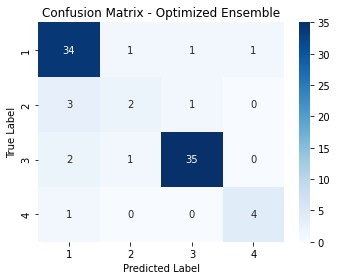

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 将模型切换到评估模式
bnn_model.eval(); simple_model.eval(); proto_model.eval(); baseline_model.eval()

# 准备训练集的tensor数据（使用完整训练集，包括之前划分出的验证集部分，以充分利用数据训练MetaLearner）
X_train_std_full_t = torch.tensor(X_train_std, dtype=torch.float32).to(device)
X_train_mm_full_t = torch.tensor(X_train_mm, dtype=torch.float32).to(device)
X_train_pca_full_t = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
X_train_raw_full_t = torch.tensor(X_train_raw, dtype=torch.float32).to(device)
y_train_full = y_train  # 完整训练集标签 (numpy)

# 获取每个子模型对完整训练集的预测概率
with torch.no_grad():
    bnn_probs_train = torch.softmax(bnn_model(X_train_std_full_t, sample=False), dim=1).cpu().numpy()
    simple_probs_train = torch.softmax(simple_model(X_train_mm_full_t), dim=1).cpu().numpy()
    proto_probs_train = torch.softmax(proto_model(X_train_pca_full_t), dim=1).cpu().numpy()
    base_probs_train = torch.softmax(baseline_model(X_train_raw_full_t), dim=1).cpu().numpy()
# 构造MetaLearner训练集特征 (N_train x 16)
meta_train_X = np.concatenate([bnn_probs_train, simple_probs_train, proto_probs_train, base_probs_train], axis=1)
meta_train_y = y_train_full

# 初始化MetaLearner
meta_input_dim = meta_train_X.shape[1]  # = num_classes * 4
meta_model = MetaLearner(input_dim=meta_input_dim, hidden_dims=[64, 32], output_dim=num_classes).to(device)
meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=0.001)

# 计算类别权重（如需要处理训练集微小的不均衡）
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(meta_train_y), y=meta_train_y)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
meta_criterion = nn.CrossEntropyLoss(weight=class_weights)

# 将MetaLearner训练数据转换为Tensor
meta_train_X_t = torch.tensor(meta_train_X, dtype=torch.float32).to(device)
meta_train_y_t = torch.tensor(meta_train_y, dtype=torch.long).to(device)

# 训练MetaLearner（采用全数据每次一个epoch，因为meta_train_X规模相对较小）
print("\n>> 开始训练 MetaLearner...")
best_meta_state = None
best_meta_loss = float('inf')
no_improve = 0
epochs_meta = 100
for epoch in range(1, epochs_meta+1):
    meta_model.train()
    # 打乱顺序
    perm = torch.randperm(meta_train_X_t.size(0))
    X_perm = meta_train_X_t[perm]
    y_perm = meta_train_y_t[perm]
    # 前向与反向传播
    outputs = meta_model(X_perm)
    loss = meta_criterion(outputs, y_perm)
    meta_optimizer.zero_grad()
    loss.backward()
    meta_optimizer.step()
    # 监控训练损失用于早停（MetaLearner无独立验证集，这里使用训练损失下降作为准则）
    cur_loss = loss.item()
    if cur_loss < best_meta_loss:
        best_meta_loss = cur_loss
        best_meta_state = {k: v.cpu() for k, v in meta_model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"MetaLearner EarlyStopping at epoch {epoch}, restoring best model.")
            if best_meta_state:
                meta_model.load_state_dict({k: v.to(device) for k, v in best_meta_state.items()})
            break
    # 每10个epoch打印一次损失
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs_meta}, MetaLearner Train Loss: {cur_loss:.4f}")
# 加载最佳MetaLearner参数
if best_meta_state:
    meta_model.load_state_dict({k: v.to(device) for k, v in best_meta_state.items()})
meta_model.eval()
print("<< MetaLearner训练完成 >>")

# **在测试集上评估集成模型**
# 将测试集数据转换为tensor并送入各子模型
X_test_std_t = torch.tensor(X_test_std, dtype=torch.float32).to(device)
X_test_mm_t = torch.tensor(X_test_mm, dtype=torch.float32).to(device)
X_test_pca_t = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
X_test_raw_t = torch.tensor(X_test_raw, dtype=torch.float32).to(device)
with torch.no_grad():
    bnn_probs_test = torch.softmax(bnn_model(X_test_std_t, sample=False), dim=1).cpu().numpy()
    simple_probs_test = torch.softmax(simple_model(X_test_mm_t), dim=1).cpu().numpy()
    proto_probs_test = torch.softmax(proto_model(X_test_pca_t), dim=1).cpu().numpy()
    base_probs_test = torch.softmax(baseline_model(X_test_raw_t), dim=1).cpu().numpy()
# 构造MetaLearner测试集输入特征
meta_test_X = np.concatenate([bnn_probs_test, simple_probs_test, proto_probs_test, base_probs_test], axis=1)
meta_test_X_t = torch.tensor(meta_test_X, dtype=torch.float32).to(device)
# MetaLearner预测输出
with torch.no_grad():
    meta_logits = meta_model(meta_test_X_t)
    meta_pred = torch.argmax(meta_logits, dim=1).cpu().numpy()
y_true = y_test  # 测试集真实标签 (numpy数组)
y_pred = meta_pred

# 计算评估指标 (Accuracy, Precision, Recall, F1-score)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
print("\nTest set evaluation results：")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision (Macro): {precision:.4f}")
print(f" Recall (Macro): {recall:.4f}")
print(f" F1-score (Macro): {f1:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
print("Confusion Matrix (counts):\n", cm)

# 绘制混淆矩阵热力图
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.title("Confusion Matrix - Optimized Ensemble")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
